In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import os
import glob
import pickle
from operator import itemgetter
import csv
from matplotlib_venn import venn3, venn3_circles,venn3_unweighted,venn2
import string 
import scipy
import seaborn as sns
from pandas import DataFrame
import matplotlib.patches as patches
import pybedtools

# Initialization

In [3]:
tool="HISAT2"
assemblers=["StringTie","IDP-STARlong"]
sample="NA12878"

ref_gtf_gencode="/path/to/gencode.v19.annotation.gtf"
ref_gtf_proteincoding="/path/to/gencode.v19.annotation.protein_coding.gtf"
ref_gtf_proteincoding_bed="/path/to/gencode.v19.annotation.protein_coding.gtf.bed"
ref_gtf_ensemble="/path/to/genes.GRCh37.gtf"
cuffcompare="/path/to/cufflinks-2.2.1.Linux_x86_64/cuffcompare"
analysis_folder="/path/to/analysis_folder"

# Predictions

In [4]:

transcripts={"StringTie":"/path/to/transcripts.gtf",
            "IDP-STARlong":"/path/to/isoform.gtf"}

# Functions

In [5]:
def parse_cuffcmp(stat_file):
    stat={}
    with open(stat_file, 'r') as input_f:
        for line in input_f:
            if (line[0] == '#'):
                if (not "Query mRNAs" in line) and (not "multi-transcript loci" in line):
                    continue
            line=line.strip()
            if not line:
                continue
            fields=line.split("\t")
            if not fields:
                continue
            if "Query mRNAs" in line:
                stat["n_t"]=int(line.split(":")[-1].split("in")[0].strip())
                stat["n_loci"]=int(line.split(":")[-1].split("in")[1].split("loci")[0].strip())
                stat["n_multiexon"]= int(line.split(":")[-1].split("(")[1].split("multi")[0].strip())
            elif "multi-transcript loci" in line:
                stat["n_multitrans"]= int(line.split("(")[1].split("multi")[0].strip())
                stat["trans_per_loci"]= float(line.split("~")[1].split("trans")[0].strip())
            elif "level" in fields[0]:
                vs=[float(v.strip()) if "-" not in v else v.strip() for v in fields[1:]]
                kys=["Sn","Sp","fSn","fSp"]
                k="_".join(fields[0].strip().split(":")[0].split())
                for i in range(4):
                    stat["%s_%s"%(k,kys[i])]=vs[i] 
            elif len(fields)==1:
                k,v=fields[0].split(":")
                stat["_".join(k.strip().split())]=int(v.strip())
            else:
                k,v=fields[0].split(":")
                k="_".join(k.strip().split())
                v1,v2=v.strip().split("/")
                p=fields[1].split("(")[-1].strip().split("%")[0]
                stat[k+'_1']=int(v1)
                stat[k+'_2']=int(v2)
                stat[k+'_r']=float(p)

    return stat

In [6]:
def generate_transcript_list(input_file):
    transcript_list=[]
    zero_fpkms=0
    with open(input_file, 'r') as input_f:
        transcript_info = ""
        exon_list = []
        for line in input_f:

            if (line[0] == '#'):
                continue

            fields = line.strip().split()
            if (fields[2] == 'transcript'):
                if (transcript_info != ""):
                    if transcript_info[8]["FPKM"][1:-1]=="*":
                        zero_fpkms+=1
                    elif not float(transcript_info[8]["FPKM"][1:-1])==0:
                        transcript_list.append(transcript_info + [exon_list])
                    else:
                        zero_fpkms+=1
                    
                    exon_list = []
                transcript_info = fields[0:8]+[{k.split()[0]:k.split()[1] for k in ' '.join(fields[8:]).split(";")[:-1]}]
            elif (fields[2] == 'exon'):
                exon_list.append([int(fields[3]), int(fields[4])])

        if (transcript_info != ""):
            if transcript_info[8]["FPKM"][1:-1]=="*":
                zero_fpkms+=1
            elif not float(transcript_info[8]["FPKM"][1:-1])==0:
                transcript_list.append(transcript_info + [exon_list])
            else:
                zero_fpkms+=1

    transcript_list=map(lambda x:[x[8]["transcript_id"] if "transcript_id" in x[8] else "",
                                 x[8]["gene_id"] if "gene_id" in x[8] else "",
                                 len(x[9]),sum(map(lambda y:abs(y[0]-y[1]),x[9]))],transcript_list)            

    return transcript_list




In [7]:
def generate_transcript_list_ref(input_file):
    transcript_list=[]
    with open(input_file, 'r') as input_f:
        transcript_info = ""
        exon_list = []
        for line in input_f:
            if (line[0] == '#'):
                continue

            fields = line.strip().split()
            if (fields[2] == 'transcript'):
                if (transcript_info != ""):
                    transcript_list.append(transcript_info + [exon_list])
                    exon_list = []
                transcript_info = fields[0:8]+[{k.split()[0]:k.split()[1] for k in ' '.join(fields[8:]).split(";")[:-1]}]
            elif (fields[2] == 'exon'):
                exon_list.append([int(fields[3]), int(fields[4])])

        if (transcript_info != ""):
            transcript_list.append(transcript_info + [exon_list])

            
    transcript_list=map(lambda x:[x[8]["transcript_id"] if "transcript_id" in x[8] else "",
                                 x[8]["gene_id"] if "gene_id" in x[8] else "",
                                 len(x[9]),sum(map(lambda y:abs(y[0]-y[1]),x[9]))],transcript_list)            
            
    return transcript_list


In [8]:
def extract_protein_coding_gtf(ref_bed,input_file):
    with open(input_file, 'r') as input_f:
        g2t_dict={}
        for line in input_f:
            if (line[0] == '#'):
                continue
            fields = line.strip().split()
 
            if (fields[2] == 'exon'):
                transcript_info={k.split()[0]:k.split()[1] for k in ' '.join(fields[8:]).split(";")[:-1]}
                tid=transcript_info["transcript_id"][1:-1]
                gid=transcript_info["gene_id"][1:-1]
                if gid not in g2t_dict:
                    g2t_dict[gid]=[]
                g2t_dict[gid].append([fields[0],min(int(fields[3]),int(fields[4])),max(int(fields[3]),int(fields[4])),tid])
        intervals=[]
        for vs in g2t_dict.values():
            ts={}
            for chrom,start,end,tid in vs:
                if tid not in ts:
                    ts[tid]=[]
                ts[tid].append([start,end])
                for tid in ts:
                    start=min(map(lambda x:x[0],ts[tid]))
                    end=max(map(lambda x:x[1],ts[tid]))
                    intervals.append(pybedtools.Interval(chrom=chrom,start=start,end=end,name=tid))
        bed=pybedtools.BedTool(intervals).sort()
        good_bed=bed.intersect(ref_bed,f=1,u=True)
        pc_names=set(map(lambda x:x[3],good_bed))
    return pc_names

In [9]:
def filter_zfpkm(input_file):
    transcript_list=[]
    zero_fpkms=0
    prev_lines=[]
    filtered_file=input_file+".zfpkm_filtered"
    with open(input_file, 'r') as input_f:
        with open(filtered_file, 'w') as filtered_f:
            fpkm = -1000000
            exon_list = []
            for line in input_f:
                if (line[0] == '#'):
                    filtered_f.write(line)
                    continue
                fields = line.strip().split()
                if (fields[2] == 'transcript'):
                    if (fpkm != -1000000):
                        if fpkm=="*":
                            zero_fpkms+=1
                        elif float(fpkm)==0:
                            zero_fpkms+=1
                        else:
                            for l in prev_lines:
                                filtered_f.write(l)
                    transcript_info = fields[0:8]+[{k.split()[0]:k.split()[1] for k in ' '.join(fields[8:]).split(";")[:-1]}]
                    fpkm=transcript_info[8]["FPKM"][1:-1]
                    prev_lines=[line]
                elif (fields[2] == 'exon'):
                    prev_lines.append(line)

            if (fpkm != -1000000):
                if fpkm=="*":
                    zero_fpkms+=1
                elif float(fpkm)==0:
                    zero_fpkms+=1
                else:
                    for l in prev_lines:
                        filtered_f.write(l)


In [10]:
def split_single_multi(input_file,out_single,out_multi):
    transcript_dict={}
    transcripts=[]
    with open(input_file, 'r') as input_f:
        for line in input_f:
            if (line[0] == '#'):
                continue
            fields = line.strip().split()
            if (fields[2] == 'exon'):
                exon_info ={k.split()[0]:k.split()[1] for k in ' '.join(fields[8:]).split(";")[:-1]}
                transcript_id=exon_info['transcript_id']
                if transcript_id not in transcript_dict:
                    transcripts.append(transcript_id)
                    transcript_dict[transcript_id]=["",[]]
                transcript_dict[transcript_id][1].append(line)
            elif (fields[2] == 'transcript'):
                trans_info ={k.split()[0]:k.split()[1] for k in ' '.join(fields[8:]).split(";")[:-1]}
                transcript_id=trans_info['transcript_id']
                if transcript_id not in transcript_dict:
                    transcripts.append(transcript_id)
                    transcript_dict[transcript_id]=["",[]]
                else:
                    print line
                    aaaa
                transcript_dict[transcript_id][0]==line
                
    cnt=len(transcripts)
    cnt_s=0
    cnt_m=0
    with open(out_single, 'w') as out_single_f:
        with open(out_multi, 'w') as out_multi_f:
            for tid in transcripts:
                tline,exonlines=transcript_dict[tid]
                if len(exonlines)==1:
                    if tline:
                        out_single_f.write(tline)
                    cnt_s+=1
                    out_single_f.write(exonlines[0])
                else:
                    if tline:
                        out_multi_f.write(tline)
                    cnt_m+=1
                    for exonline in exonlines:
                        out_multi_f.write(exonline)
    
    return cnt,cnt_s,cnt_m

In [11]:
def parse_cuffcmp_all(cuffcmp_prefix):
    tags=assemblers
    codes=["=","c","j","e","i","o","p","r","u","x","s","."]
    common_ts={}
    n_ts={}
    for i,q1 in enumerate(tags):
        n_ts[q1]={k:0 for k in codes}
        common_ts[q1]={}
        for j,q2 in enumerate(tags):
            if i<j:
                common_ts[q1][q2]={k:0 for k in codes}
    with open(cuffcmp_prefix+".tracking") as csv_file:
        spamreader = csv.reader(csv_file, delimiter='\t', quotechar='|')
        for row in spamreader:
            code=row[3]
            nz_qs=map(lambda j:tags[j],sorted([i for i,w in enumerate(row[4:]) if w!="-"]))
            for q in nz_qs:
                n_ts[q][code]+=1
            for i,q1 in enumerate(nz_qs):
                for j,q2 in enumerate(nz_qs):
                    if i<j:
                        common_ts[q1][q2][code]+=1
    return common_ts,n_ts

# Analysis

## Read Assembly transcripts

In [12]:
if not os.path.exists("%s/ensemble-gencode.stats"%analysis_folder):
    cmd="%s \
    -o %s/ensemble-gencode\
    -r %s -R %s"%(cuffcompare,analysis_folder,ref_gtf_ensemble,ref_gtf_gencode)
    print cmd
    a=os.system(cmd)
    if a!=0:
        print "a",a
with open("%s/ensemble-gencode.tracking"%analysis_folder) as csv_file:
    spamreader = csv.reader(csv_file, delimiter='\t', quotechar='|')
    new_trans={"u":[],"j":[],"i":[]}
    for row in spamreader:
        code=row[3]
        if code in new_trans.keys():
            new_trans[code].append(row[4].split("|")[1])

new_gencode_gtf="%s/gencode_new.gtf"%analysis_folder
with open(ref_gtf_gencode) as i_file:
    with open(new_gencode_gtf,"w") as o_file:
        for line in i_file:
            if line[0]=="#":
                continue
            fields=line.split("\t")
            transcript_info={k.split()[0]:k.split()[1][1:-1] for k in ' '.join(fields[8:]).split(";")[:-1]}
            transcript_id=transcript_info["transcript_id"]
            if transcript_id in new_trans["u"] or \
                transcript_id in new_trans["i"] or \
                transcript_id in new_trans["j"]:
                o_file.write(line)




In [13]:
transcript_file={}
transcript_list={}
for assembler in assemblers:
    filter_zfpkm(transcripts[assembler])                    
    transcript_file[assembler]="%s.zfpkm_filtered"%transcripts[assembler]      
    cmd="%s -o \
              %s/cuffcmp_gencode_%s -r \
              %s -R %s"%(cuffcompare,analysis_folder,assembler,ref_gtf_gencode,transcript_file[assembler])
    if not os.path.exists("%s/cuffcmp_gencode_%s.stats"%(analysis_folder,assembler)):
        a=os.system(cmd)
        print cmd
        if a!=0:
            print "a",a

    cmd="%s -o \
              %s/cuffcmp_gencode_new_%s -r \
              %s -R %s"%(cuffcompare,analysis_folder,assembler,new_gencode_gtf,transcript_file[assembler])
    if not os.path.exists("%s/cuffcmp_gencode_new_%s.stats"%(analysis_folder,assembler)):
        a=os.system(cmd)
        print cmd
        if a!=0:
            print "a",a
    transcript_list[assembler]=generate_transcript_list(transcripts[assembler])

transcript_file["gencode"]=ref_gtf_gencode
transcript_list["gencode"]=generate_transcript_list_ref(ref_gtf_gencode)

transcript_file["new"]=new_gencode_gtf
transcript_list["new"]=generate_transcript_list_ref(new_gencode_gtf)

# Calculate Stats

In [14]:
transcript_stats={assembler:{} for assembler in assemblers}
transcript_stats["gencode"]={}
transcript_stats["new"]={}

### exon per transcript

In [15]:
for assembler in transcript_stats.keys():
    counts=map(lambda x: x[2],transcript_list[assembler])
    mean_ex_lens=np.mean(map(lambda x: x[3],transcript_list[assembler]))
    hist_c={ x: counts.count(x) for x in range(0,max(counts)+1)}
    hist_c_=[hist_c[1],hist_c[2]+hist_c[3],hist_c[4]+hist_c[5],sum(map(lambda x:x[1] if x[0]>5 else 0,hist_c.items()))]
    transcript_stats[assembler].update({"1-exon":round(hist_c_[0]/float(len(counts))*100,1),\
                                            "2_3-exon":round(hist_c_[1]/float(len(counts))*100,1),\
                                            "4_5-exon":round(hist_c_[2]/float(len(counts))*100,1),\
                                            "g_5-exon":round(hist_c_[3]/float(len(counts))*100,1),\
                                            "hist_exon":hist_c,\
                                            "mean_n_exon":np.mean(counts),\
                                            "median_n_exon":np.median(counts),
                                            "mean_ex_lens":mean_ex_lens 
                                                          })

### number of transcript and genes

In [16]:
for assembler in transcript_stats.keys():
    n_transcripts=len(set(map(lambda x: x[0][1:-1],transcript_list[assembler])))
    n_genes=len(set(map(lambda x: x[1][1:-1],transcript_list[assembler])))
    gid_dict={}
    for x in transcript_list[assembler]:
        gid=x[1][1:-1]
        tid=x[0][1:-1]
        if gid not in gid_dict:
            gid_dict[gid]=[]
        gid_dict[gid].append(tid)
    tpg=[len(v) for k,v in gid_dict.iteritems()]
    len_trans=map(lambda x: x[3],transcript_list[assembler])
    transcript_stats[assembler].update({"n_trans":n_transcripts,"n_genes":n_genes})
    hist_g={ x: tpg.count(x) for x in range(0,max(max(tpg)+1,6))}
    hist_g_=[hist_g[1],hist_g[2]+hist_g[3],hist_g[4]+hist_g[5],sum(map(lambda x:x[1] if x[0]>5 else 0,hist_g.items()))]
    transcript_stats[assembler].update({"1-trans":round(hist_g_[0]/float(len(tpg))*100,1),\
                                            "2_3-trans":round(hist_g_[1]/float(len(tpg))*100,1),\
                                            "4_5-trans":round(hist_g_[2]/float(len(tpg))*100,1),\
                                            "g_5-trans":round(hist_g_[3]/float(len(tpg))*100,1),\
                                            "hist_trans":hist_g,\
                                            "mean_n_trans":np.mean(tpg),\
                                            "mean_len_trans":np.mean(len_trans),\
                                            "sum_len_trans":sum(len_trans),\
                                            "median_len_trans":np.median(len_trans),\
                                            "median_n_trans":np.median(tpg),\
                                                          })


### cuffcompare

In [17]:
for assembler in assemblers:
    stat_path="%s/cuffcmp_gencode_%s.stats"%(analysis_folder,assembler) 
    transcript_stats[assembler].update(parse_cuffcmp(stat_path))


In [18]:
ts_dict_new=dict(map(lambda z:(z[0][1:-1] if z[0][0]=='"' else z[0],z[1]),(map(lambda y:(y[0],y[2]),
                         transcript_list["new"]))))

new_gene_to_trans={}
for tt in transcript_list["new"]:
    gid=tt[1][1:-1]
    tid=tt[0][1:-1]
    if gid not in new_gene_to_trans:
        new_gene_to_trans[gid]=[]
    new_gene_to_trans[gid].append(tid)
    

In [19]:
gc_ens={}
codes=["=","c","j","e","i","o","p","r","u","x","s","."]
gc_ens={}
for assembler in assemblers:
    gc_ens[assembler]={"all":{k:0 for k in codes},"multi":{k:0 for k in codes}}
    stat_path="%s/cuffcmp_gencode_new_%s.tracking"%(analysis_folder,assembler) 
    with open(stat_path) as csv_file:
        spamreader = csv.reader(csv_file, delimiter='\t', quotechar='|')
        for row in spamreader:
            gc_ens[assembler]["all"][row[3]]+=1
            if row[2]!="-":
                ref_tid=row[2].split("|")[1]
                if ref_tid[0:4]=="ENSG":
                    ref_tid=row[2].split("|")[1]
                    if 1 in map(lambda x:ts_dict_new[x],new_gene_to_trans[ref_tid]):
                        continue
                    gc_ens[assembler]["multi"][row[3]]+=1
                else:
                    if ts_dict_new[ref_tid]>1:
                        gc_ens[assembler]["multi"][row[3]]+=1

## Novel Transcripts

In [20]:
gtfs=[]
for assembler in assemblers:
    gtfs.append(transcript_file[assembler])
cmd="%s -o \
          %s/cuffcmp_gencode_all -r \
          %s -R %s"%(cuffcompare,analysis_folder,ref_gtf_gencode," ".join(gtfs))
if not os.path.exists("%s/cuffcmp_gencode_all.stats"%analysis_folder) :
    print cmd
    a=os.system(cmd)
    if a!=0:
        print "a",a

In [21]:
def find_uniq(cuffcmp_prefix,method):
    tags=assemblers
    codes=["=","c","j","e","i","o","p","r","u","x","s","."]
    uniq={}
    uniq_ref={}
    uniq_only={}
    with open(cuffcmp_prefix+".tracking") as csv_file:
        spamreader = csv.reader(csv_file, delimiter='\t', quotechar='|')
        for row in spamreader:
            code=row[3]
            if code not in uniq:
                uniq[code]={}
                uniq_ref[code]={}
                uniq_only[code]=[]
            qs_dict=dict(map(lambda j:[tags[j[0]],j[1]],enumerate(row[4:])))
            nz_qs=map(lambda j:tags[j],sorted([i for i,w in enumerate(row[4:]) if w!="-"]))
            if method=="LR":
                main=filter(lambda x: ("IDP" in x), nz_qs)
                other=filter(lambda x: ("IDP" not in x), nz_qs)
            elif method=="SR":
                other=filter(lambda x: ("IDP" in x) , nz_qs)
                main=filter(lambda x: ("IDP" not in x), nz_qs)
            if len(other)==0 and len(main)>0:
                flag=0
                for t in main:
                    if t not in uniq[code]:
                        uniq[code][t]=[]
                        uniq_ref[code][t]=[]
                    uniq[code][t].append(qs_dict[t])
                    uniq_ref[code][t].append(row[2])
                    if flag==0:
                        uniq_only[code].append([t,qs_dict[t]])
                        flag=1
    return uniq,uniq_ref,uniq_only



In [22]:
uniq={}
uniq_ref={}
uniq_only={}
for method in ["LR","SR"]:
    uniq[method],uniq_ref[method],uniq_only[method]=find_uniq(
                                                "%s/cuffcmp_gencode_all"%
                                              (analysis_folder),method)

In [23]:
exon_stats_uniq={}
for method in ["LR","SR"]:
    exon_stats_uniq[method]={}
    for code in uniq[method]:
        exon_stats_uniq[method][code]={}
        for mth in uniq[method][code]:
            ts=uniq[method][code][mth]
            tids=map(lambda x:x.split("|")[5] if len(x.split("|"))==12 else x.split("|")[1],ts)
            ts_dict=dict(map(lambda z:(z[0][1:-1] if z[0][0]=='"' else z[0],z[1]),(map(lambda y:(y[0],y[2]),
                                         transcript_list[mth]))))
            ts_L_dict=dict(map(lambda z:(z[0][1:-1] if z[0][0]=='"' else z[0],z[1]),(map(lambda y:(y[0],
                                                            y[3]),
                                         transcript_list[mth]))))
            ts_en={k:0 for k in ["1-exon","2_3-exon","4_5-exon","g_5-exon"]}
            ts_en["lens"]=[]
            for tid in tids:
                n_exon=ts_dict[tid]
                if n_exon==1:
                    ts_en["1-exon"]+=1
                elif 2<=n_exon<=3:
                    ts_en["2_3-exon"]+=1
                elif 4<=n_exon<=5:
                    ts_en["4_5-exon"]+=1
                elif n_exon>5:
                    ts_en["g_5-exon"]+=1
                ts_en["lens"].append(ts_L_dict[tid])
            exon_stats_uniq[method][code][mth]=ts_en


In [24]:
len_t_tbf={}
for method in ["LR","SR"]:
    for code in uniq[method]:
        for mth,ts in uniq_only[method][code]:
            if mth not in len_t_tbf:
                len_t_tbf[mth]=[]
            tid=ts.split("|")[5] if len(ts.split("|"))==12 else ts.split("|")[1]
            len_t_tbf[mth].append(tid)

In [25]:
len_t={}
for mth in assemblers:
    len_t[mth]={}
    ts_dict=dict(map(lambda z:(z[0][1:-1] if z[0][0]=='"' else z[0],z[1]),(map(lambda y:(y[0],(y[2])),
                                 transcript_list[mth]))))
    ts_L_dict=dict(map(lambda z:(z[0][1:-1] if z[0][0]=='"' else z[0],z[1]),(map(lambda y:(y[0],
                                                    y[3]),
                                 transcript_list[mth]))))
    for tid in len_t_tbf[mth]:
        len_t[mth][tid]=ts_L_dict[tid]


In [26]:
len_stats={}
for method in ["LR","SR"]:
    len_stats[method]={}
    for code in uniq_only[method]:
        len_stats[method][code]=[]
        for mth,ts in uniq_only[method][code]:
            tid=ts.split("|")[5] if len(ts.split("|"))==12 else ts.split("|")[1]
            len_stats[method][code].append(len_t[mth][tid])


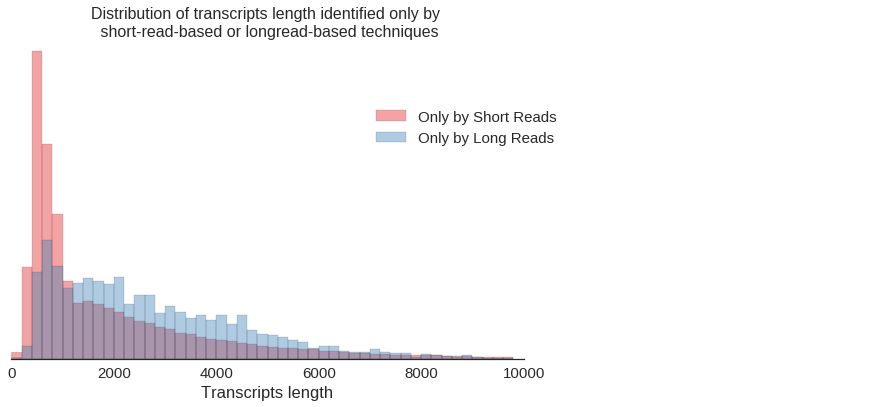

In [27]:
sns.set(style="white",font_scale=1.5)    
some_codes=["=","c","j","e","i","o","p","r","u","x","s","."]
fig, ax = plt.subplots(figsize=(8,6))
my_colors=sns.color_palette("Set1",n_colors=10)

labels=[]
Ls=[]
L_SR=[]
for code in some_codes:
    if code in len_stats["SR"]:
        L_SR+=len_stats["SR"][code]
Ls.append(L_SR)
labels.append("Only by Short Reads")
L_LR=[]
for code in some_codes:
    if code in len_stats["LR"]:
        L_LR+=len_stats["LR"][code]
Ls.append(L_LR)
labels.append("Only by Long Reads")

for i,L in enumerate(Ls):
    sns.distplot(L, kde=False, bins=range(0,10000,200),color=my_colors[i],norm_hist=True, ax=ax,)
ax.set_xlim([0,10000])
ax.set_yticks([])
ax.set_xlabel("Transcripts length")
ax.set_title("Distribution of transcripts length identified only by \n short-read-based or longread-based techniques",fontsize=16)
sns.despine(left=True)    
ax.legend(labels,bbox_to_anchor=(0.7, 0.7, 1, .102), 
      loc=1,ncol=1,
      mode="expand", borderaxespad=0.,frameon=False)

plt.tight_layout()


## per exon-number accuracies

In [28]:
exon_stats={}
for assembler in assemblers:
    exon_stats[assembler]={}
    ts_dict=dict(map(lambda z:(z[0][1:-1] if z[0][0]=='"' else z[0],z[1]),(map(lambda y:(y[0],y[2]),
                         transcript_list[assembler]))))
    ts_en={k:{"=":0,".":0} for k in ["1","2-3","4-5","g5"]}
    with open("%s/cuffcmp_gencode_%s.tracking"%(analysis_folder,assembler)) as csv_file:
        spamreader = csv.reader(csv_file, delimiter='\t', quotechar='|')
        for row in spamreader:
            code="=" if row[3]=="="   else "."
            res=row[4]
            if "||" in res:
                tid1=res.split("||")[2].split("|")[0]
            else:
                tid1=res.split("|")[1]
            n_exon=ts_dict[tid1]
            if n_exon==1:
                ts_en["1"][code]+=1
            elif 2<=n_exon<=3:
                ts_en["2-3"][code]+=1
            elif 4<=n_exon<=5:
                ts_en["4-5"][code]+=1
            elif n_exon>5:
                ts_en["g5"][code]+=1
    exon_stats[assembler]=ts_en


In [29]:
exon_stats_detail={}
for assembler in assemblers:
    ts_dict=dict(map(lambda z:(z[0][1:-1] if z[0][0]=='"' else z[0],z[1]),(map(lambda y:(y[0],y[2]),
                                 transcript_list[assembler]))))
    ts_en={k:[0 for i in range(100)] for k in ["=","."]}
    with open("%s/cuffcmp_gencode_%s.tracking"%(analysis_folder,assembler)) as csv_file:
        spamreader = csv.reader(csv_file, delimiter='\t', quotechar='|')
        for row in spamreader:
            code="=" if row[3]=="="   else "."
            res=row[4]
            if "||" in res:
                tid1=res.split("||")[2].split("|")[0]
            else:
                tid1=res.split("|")[1]
            n_exon=min(ts_dict[tid1],100)-1
            ts_en[code][n_exon]+=1
    exon_stats_detail[assembler]=ts_en


In [30]:
n_trans={}
for assembler in assemblers:
    n_1=sum(exon_stats[assembler]["1"].values())
    n=sum([sum(exon_stats[assembler][x].values()) for x in exon_stats[assembler]])
    n_trans[assembler]={"1":n_1,"g1":n-n_1}

In [31]:
single_multi_count={}
for assembler in transcript_file:
    single_multi_count[assembler]={}
    tf=transcript_file[assembler]
    of_s=tf+".signle.gtf"
    of_m=tf+".multi.gtf"
    if not os.path.exists(of_s) or not os.path.exists(of_m):
        cnt,cnt_s,cnt_m=split_single_multi(tf,of_s,of_m)
        single_multi_count[assembler]=[cnt,cnt_s,cnt_m]
    cmd="%s -o \
              %s/cuffcmp_gencode_%s_single -r \
              %s -R %s"%(cuffcompare,analysis_folder,assembler,ref_gtf_gencode,of_s)
    if not os.path.exists("%s/cuffcmp_gencode_%s_single.stats"%(analysis_folder,assembler)):
        a=os.system(cmd)
        print cmd
        if a!=0:
            print "a",a
    cmd="%s -o \
              %s/cuffcmp_gencode_%s_multi -r \
              %s -R %s"%(cuffcompare,analysis_folder,assembler,ref_gtf_gencode,of_m)
    if not os.path.exists("%s/cuffcmp_gencode_%s_multi.stats"%(analysis_folder,assembler)):
        a=os.system(cmd)
        print cmd
        if a!=0:
            print "a",a


In [32]:
single_multi_stats={}
for assembler in assemblers:
    single_multi_stats[assembler]={}
    tf=transcript_file[assembler]
    for sm in ["single","multi"]:
        stat_path="%s/cuffcmp_gencode_%s_%s.stats"%(analysis_folder,assembler,sm)             
        s=parse_cuffcmp(stat_path)
        single_multi_stats[assembler][sm]=s
        res_stat=exon_stats[assembler]
        if sm=="single":
            a=res_stat["1"]["="]/float(res_stat["1"]["="]+res_stat["1"]["."]+0.0001)
        else:
            a=(sum([res_stat[k]["="] for k in ["2-3","4-5","g5"]]))/float(
                (sum([res_stat[k]["="] for k in ["2-3","4-5","g5"]]))+(
                    sum([res_stat[k]["."] for k in ["2-3","4-5","g5"]]))+0.0001)
        n=n_trans[assembler]["1" if sm=="single" else "g1"]
        n2=s["n_t"]


In [33]:
codes=["=","c","j","e","i","o","p","r","u","x","s","."]
good_calls={}
all_calls={}
cuffcmp_prefix="%s/cuffcmp_gencode_all"%(analysis_folder)
if os.path.exists(cuffcmp_prefix+".stats"):
    with open(cuffcmp_prefix+".stats") as stat_file:
        tags=list(enumerate(assemblers))
    lr_tags=filter(lambda x: "IDP" in x[1],tags)
    sr_tags=filter(lambda x: "IDP" not in x[1],tags)
    lr_ids=set(map(lambda x:x[0],lr_tags))
    sr_ids=set(map(lambda x:x[0],sr_tags))
    lr_ids_assembler={}
    for k,assembler in lr_tags:
        if assembler not in lr_ids_assembler:
            lr_ids_assembler[assembler]=[]
        lr_ids_assembler[assembler].append(k)
    sr_ids_assembler={}
    for k,assembler in sr_tags:
        if assembler not in sr_ids_assembler:
            sr_ids_assembler[assembler]=[]
        sr_ids_assembler[assembler].append(k)
    for idx,assembler in lr_tags+sr_tags:
        good_calls[assembler]={x:0 for x in codes}
        all_calls[assembler]={x:0 for x in codes}
        with open(cuffcmp_prefix+".tracking") as csv_file:
            spamreader = csv.reader(csv_file, delimiter='\t', quotechar='|')
            for row in spamreader:
                code=row[3]
                if row[4+idx]=="-":
                    continue
                ids=set(map(lambda y:y[0],filter(lambda x: x[1]!="-",enumerate(row[4:]))))
                ids=ids-set([idx])
                ll=lr_ids-(set(lr_ids_assembler[assembler]) if assembler in lr_ids_assembler else set([]))
                ss=sr_ids-(set(sr_ids_assembler[assembler]) if assembler in sr_ids_assembler else set([]))
                if ids&(ll|ss):
                    good_calls[assembler][code]+=1
                all_calls[assembler][code]+=1                            

# Plots

[array([ 15.54167365,  90.53977034]), array([ 0.61712011,  8.24468081])]


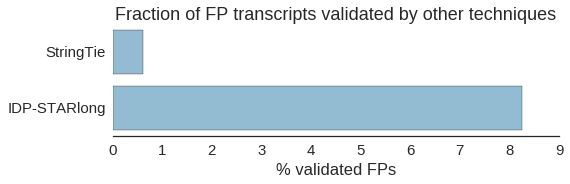

In [34]:
sns.set(style="white",font_scale=1.5)    
my_palette=sns.color_palette("Blues",n_colors=6)
codes_tp=["="]
codes_fp=["c","j","e","i","o","p","r","u","x","s","."]
fig,ax = plt.subplots(figsize=(8, 2)) 
res=[]
A=[]
B=[]
labels=[]
for assembler in assemblers:
    cnt_good_tp= sum(map(lambda y:y[1],filter(lambda x: x[0] in codes_tp,good_calls[assembler].items())))
    cnt_all_tp= sum(map(lambda y:y[1],filter(lambda x:  x[0] in codes_tp,all_calls[assembler].items())))
    cnt_good_fp= sum(map(lambda y:y[1],filter(lambda x: x[0] in codes_fp,good_calls[assembler].items())))
    cnt_all_fp= sum(map(lambda y:y[1],filter(lambda x:  x[0] in codes_fp,all_calls[assembler].items())))
    A.append(cnt_good_tp/float(cnt_all_tp+0.00001)*100)
    B.append(cnt_good_fp/float(cnt_all_fp+0.00001)*100)
    labels.append(assembler)
res=[np.array(A),np.array(B)]
print res
my_data_tp=DataFrame(np.array(res).transpose(),index=labels,columns=["TP","FP"])
cg=sns.barplot(data=my_data_tp,y=labels,x="FP", color=my_palette[2],ax=ax)
ax.set_xlabel("% validated FPs")
ax.set_title("Fraction of FP transcripts validated by other techniques")
sns.despine(left=True)    




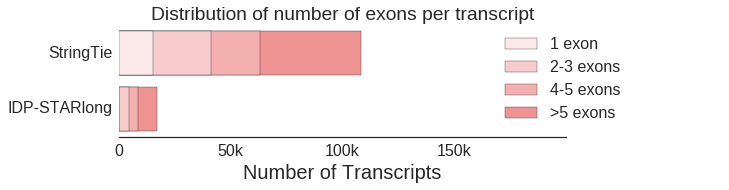

In [35]:
from matplotlib import gridspec

sns.set(style="white",font_scale=1.6)    
my_palette=sns.light_palette("red",n_colors=8)
fig,ax = plt.subplots(figsize=(8, 2)) 
bin_labels=["1 exon","2-3 exons","4-5 exons", ">5 exons"]
res=[]
A=[]
B=[]
C=[]
D=[]
labels=[]
for assembler in assemblers:
    tot=sum(transcript_stats[assembler]["hist_exon"].values())/100.0
    A.append(transcript_stats[assembler]["1-exon"]*tot)
    B.append(transcript_stats[assembler]["2_3-exon"]*tot)
    C.append(transcript_stats[assembler]["4_5-exon"]*tot)
    D.append(transcript_stats[assembler]["g_5-exon"]*tot)
    labels.append(assembler)
res.append(np.array(D)+np.array(C)+np.array(B)+np.array(A))
res.append(np.array(C)+np.array(B)+np.array(A))
res.append(np.array(B)+np.array(A))
res.append(np.array(A))
my_data=DataFrame(np.array(res).transpose(),index=labels,columns=bin_labels[::-1])
for ii,b in enumerate(bin_labels[::-1]):
    cg=sns.barplot(data=my_data,x=b,y=labels,label=b, color=my_palette[len(bin_labels)-ii-1],ax=ax)
ax.set_xticks(range(0,250000,50000))
ax.set_xticklabels(["%sk"%(x/1000) if x>0 else "0" for x in range(0,200000,50000)])
ax.set_xlim([0,200000])
ax.set_xlabel( "Number of Transcripts" ,fontsize=20)
sns.despine(left=True)    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(0.85, .85, 0.5, .102), 
      loc=1,ncol=1,
      mode="expand", borderaxespad=0.,frameon=False)
ax.set_title("Distribution of number of exons per transcript")


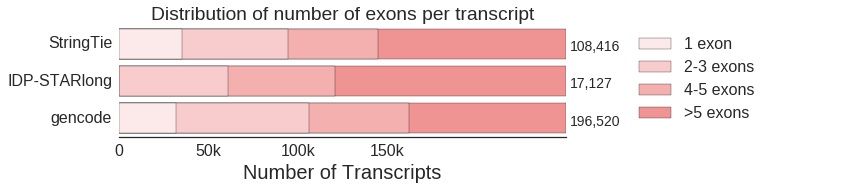

In [36]:
from matplotlib import gridspec

sns.set(style="white",font_scale=1.6)    
my_palette=sns.light_palette("red",n_colors=8)
fig,ax = plt.subplots(figsize=(8, 2)) 
bin_labels=["1 exon","2-3 exons","4-5 exons", ">5 exons"]
res=[]
A=[]
B=[]
C=[]
D=[]
labels=[]
nlabel={}
for assembler in assemblers+["gencode"]:
    A.append(transcript_stats[assembler]["1-exon"])
    B.append(transcript_stats[assembler]["2_3-exon"])
    C.append(transcript_stats[assembler]["4_5-exon"])
    D.append(transcript_stats[assembler]["g_5-exon"])
    labels.append(assembler)
    nlabel[assembler]=sum(transcript_stats[assembler]["hist_exon"].values())
    
res.append(np.array(D)+np.array(C)+np.array(B)+np.array(A))
res.append(np.array(C)+np.array(B)+np.array(A))
res.append(np.array(B)+np.array(A))
res.append(np.array(A))
my_data=DataFrame(np.array(res).transpose(),index=labels,columns=bin_labels[::-1])
for ii,b in enumerate(bin_labels[::-1]):
    cg=sns.barplot(data=my_data,x=b,y=labels,label=b, color=my_palette[len(bin_labels)-ii-1],ax=ax)
for ii,label in enumerate(labels):
    ax.text(101,ii+.2,"%d,%03d"%(nlabel[label]/1000,nlabel[label]%1000) if nlabel[label]>=1000 else nlabel[label] ,fontsize=14)
    ax.set_xticks(range(0,120,20))
ax.set_xticklabels(["%sk"%(x/1000) if x>0 else "0" for x in range(0,200000,50000)])
ax.set_xlim([0,100])
ax.set_xlabel( "Number of Transcripts" ,fontsize=20)
sns.despine(left=True)    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.15, .85, 0.5, .102), 
      loc=1,ncol=1,
      mode="expand", borderaxespad=0.,frameon=False)
ax.set_title("Distribution of number of exons per transcript")


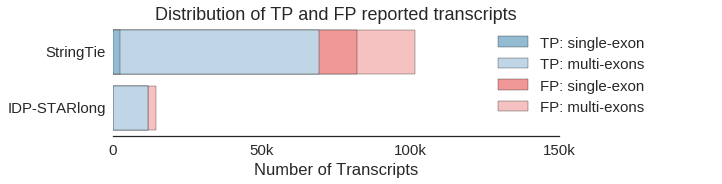

In [37]:
sns.set(style="white",font_scale=1.5)    
my_palette_1=sns.light_palette("red",n_colors=6)
my_palette_2=sns.color_palette("Blues",n_colors=6)
my_palette=[my_palette_1[1],my_palette_1[2],my_palette_2[1],my_palette_2[2]]
fig, ax = plt.subplots(figsize=(8,2))
bin_labels=["TP: single-exon","TP: multi-exons","FP: single-exon","FP: multi-exons"]
res=[]
A=[]
B=[]
A2=[]
B2=[]
labels=[]
for assembler in assemblers:
    res_stat=single_multi_stats[assembler]
    kk="Transcript_level_Sp"
    s=res_stat["single"][kk]/100.0 if kk in res_stat["single"] else 0
    m=res_stat["multi"][kk]/100.0 if kk in res_stat["multi"] else 0
    n_s=res_stat["single"]["n_t"]
    n_m=res_stat["multi"]["n_t"]
    A.append(n_s*s)
    B.append(n_m*m)
    A2.append(n_s*(1-s))
    B2.append(n_m*(1-m))
    labels.append(assembler)

res.append(np.array(B)+np.array(A)+np.array(B2)+np.array(A2))
res.append(np.array(B)+np.array(A)+np.array(A2))
res.append(np.array(B)+np.array(A))
res.append(np.array(A))
my_data=DataFrame(np.array(res).transpose(),index=labels,columns=bin_labels[::-1])
for ii,b in enumerate(bin_labels[::-1]):
    cg=sns.barplot(data=my_data,x=b,y=labels,label=b, color=my_palette[ii],ax=ax)
ax.set_xlabel("Number of Transcripts")
ax.set_xticks(range(0,200000,50000))
ax.set_xticklabels(["%sk"%(x/1000) if x>0 else "0" for x in range(0,200000,50000)])
ax.set_xlim([0,150000])
sns.despine(left=True)    
handles, labels = ax.get_legend_handles_labels()
# reverse the order
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(0.85,0.85, 0.5, .102), 
      loc=1,ncol=1,
      mode="expand", borderaxespad=0.,frameon=False)
ax.set_title("Distribution of TP and FP reported transcripts")



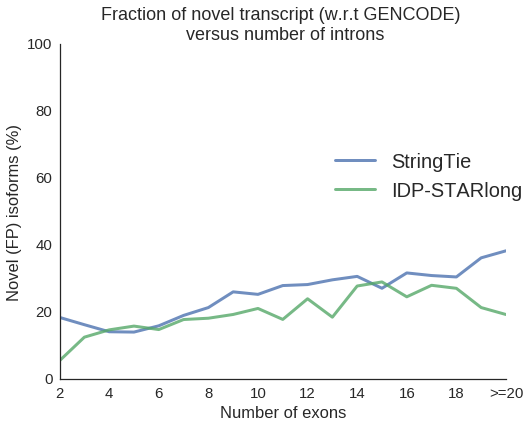

In [38]:
sns.set(style="white",font_scale=1.5)    
my_colors=sns.color_palette("Set1",n_colors=10)
nmax=20                           
fig, ax = plt.subplots(figsize=(8,6))
bin_labels=["TP: single-exon","TP: multi-exons","FP: single-exon","FP: multi-exons"]
res=[]
A=[]
B=[]
C=[]
D=[]
A2=[]
B2=[]
C2=[]
D2=[]
labels=[]
for assembler in assemblers:
    res_stat=exon_stats_detail[assembler]
    res_stat={k:v[1:(nmax-1)]+[sum(v[(nmax-1):])] for k,v in res_stat.iteritems()}
    trend=map(lambda x: x[1]/float((x[0]+x[1]+0.000001))*100,zip(res_stat["="],res_stat["."]))
    ax.plot(range(2,nmax+1),trend,alpha=0.8,
            linewidth=3,label=assembler)

ax.set_xlabel("Number of exons")
ax.set_ylabel("Novel (FP) isoforms (%)")
ax.set_xticks(range(2,nmax+1,2))
ax.set_xticklabels([">=%d"%(nmax) if x==(nmax) else x for x in range(2,nmax+1,2)])
ax.set_xlim([2,nmax])
ax.set_ylim([0,100])

sns.despine()    
ax.legend(bbox_to_anchor=(0.6, 0.6, 0.4, .102), 
  loc=1,ncol=1,
  mode="expand", borderaxespad=0.,frameon=False,fontsize=20)
ax.set_title("Fraction of novel transcript (w.r.t GENCODE) \n versus number of introns")


[array([ 100. ,  100.1,  100. ]), array([ 78.1,  94.3,  81.4]), array([ 70.3,  83.1,  74.8]), array([ 59. ,  45.9,  61.6])]


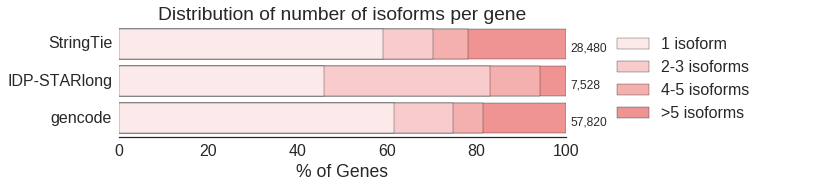

In [39]:
sns.set(style="white",font_scale=1.6)    
fig,ax = plt.subplots(figsize=(8, 2)) 
bin_labels=["1 isoform","2-3 isoforms","4-5 isoforms", ">5 isoforms"]
res=[]
A=[]
B=[]
C=[]
D=[]
labels=[]
nlabel={}
my_palette=sns.light_palette("red",n_colors=8)
for assembler in assemblers+["gencode"]:
    A.append(transcript_stats[assembler]["1-trans"])
    B.append(transcript_stats[assembler]["2_3-trans"])
    C.append(transcript_stats[assembler]["4_5-trans"])
    D.append(transcript_stats[assembler]["g_5-trans"])
    labels.append(assembler)
    nlabel[assembler]=sum(transcript_stats[assembler]["hist_trans"].values())            

res.append(np.array(D)+np.array(C)+np.array(B)+np.array(A))
res.append(np.array(C)+np.array(B)+np.array(A))
res.append(np.array(B)+np.array(A))
res.append(np.array(A))
print res
my_data=DataFrame(np.array(res).transpose(),index=labels,columns=bin_labels[::-1])
for ii,b in enumerate(bin_labels[::-1]):
    cg=sns.barplot(data=my_data,x=b,y=labels,label=b, color=my_palette[len(bin_labels)-ii-1],ax=ax)
for ii,label in enumerate(labels):
    ax.text(101,ii+.2,"%d,%03d"%(nlabel[label]/1000,nlabel[label]%1000) if nlabel[label]>=1000 else nlabel[label] ,fontsize=12)
ax.set_xlabel("% of Genes")
ax.set_xticks(range(0,120,20))
ax.set_xlim([0,100])
sns.despine(left=True)
handles, labels = ax.get_legend_handles_labels()
# reverse the order
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.1, 0.85, 0.5, .102), 
  loc=1,ncol=1,
  mode="expand", borderaxespad=0.,frameon=False)
ax.set_title("Distribution of number of isoforms per gene")



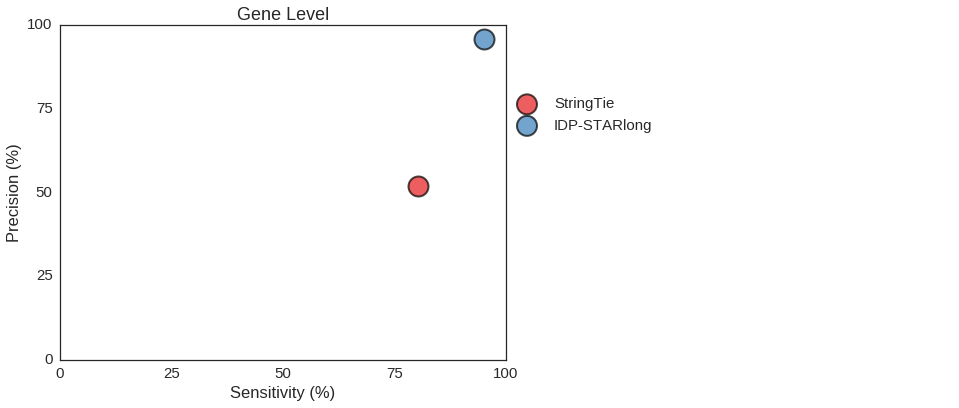

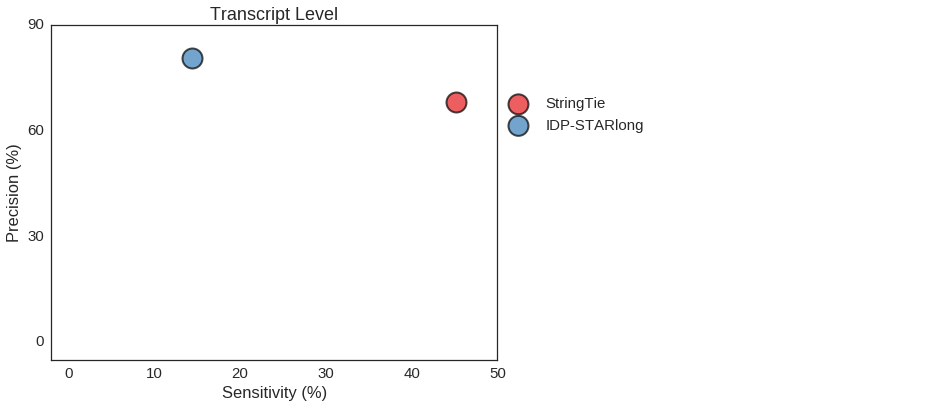

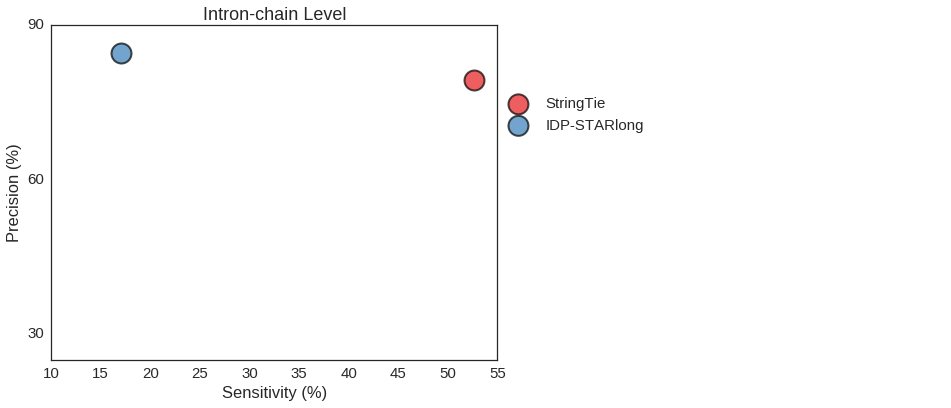

In [40]:
sns.set(style="white",font_scale=1.5)    
my_colors=sns.color_palette("Set1",n_colors=10)
for kkk,level in enumerate(["Locus","Transcript","Intron_chain"]):
    fig, ax = plt.subplots(figsize=(8,6))
    labels=assemblers
    legs=[]
    for ii,assembler in enumerate(assemblers):
        A=(transcript_stats[assembler]["%s_level_Sn"%(level)])
        B=(transcript_stats[assembler]["%s_level_Sp"%(level)])
        ax.scatter(A, B, 400,alpha=0.7,
                   edgecolor='k',
                linewidth=2,
                   color=my_colors[ii],
                   marker="o",
                   label=assembler,
                   clip_on=False
                  )
    if level=="Locus":
        ax.set_xticks(range(0,105,25))
        ax.set_yticks(range(0,110,25))
        ax.set_title("Gene Level")
    elif level=="Transcript":
        ax.set_xticks(range(0,60,10))
        ax.set_xlim([-2,50])
        ax.set_yticks(range(0,100,30))
        ax.set_ylim([-5,90])
        ax.set_title("Transcript Level")
    elif level=="Intron_chain":
        ax.set_xticks(range(10,60,5))
        ax.set_yticks(range(30,100,30))
        ax.set_ylim([25,90])
        ax.set_title("Intron-chain Level")
    ax.legend(bbox_to_anchor=(1, 0.5, 1, .302), loc=1,ncol=1,
              mode="expand", borderaxespad=0.,frameon=False)
    ax.set_ylabel("Precision (%)")
    ax.set_xlabel("Sensitivity (%)")


In [41]:
data_f=[]
for kkk,level in enumerate(["Locus","Transcript","Intron_chain"]):
    for aaa,assembler in enumerate(assemblers):
        A=(transcript_stats[assembler]["%s_level_Sn"%(level)])
        B=(transcript_stats[assembler]["%s_level_Sp"%(level)])
        data_f.append([assembler,level,A,"Sensitivity"])
        data_f.append([assembler,level,B,"Precision"])

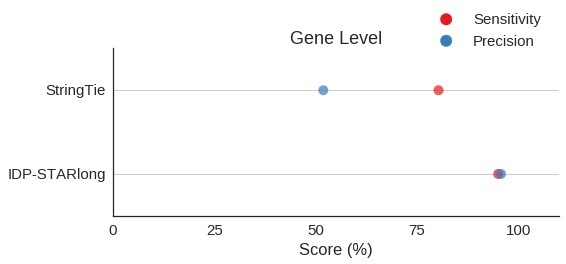

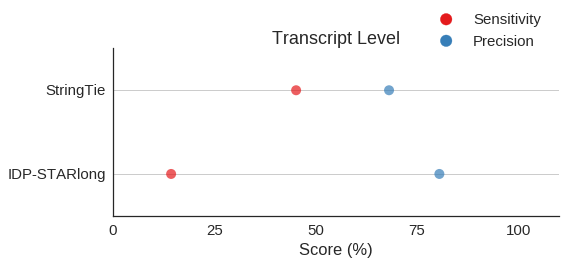

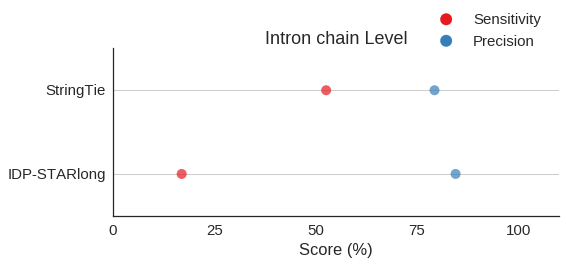

In [42]:
sns.set(style="white",font_scale=1.5)    
my_colors=sns.color_palette("Set1",n_colors=10)

for kkk,level in enumerate(["Locus","Transcript","Intron_chain"]):
    fig, ax = plt.subplots(figsize=(8,3))
    my_data=DataFrame(data_f,
                      columns=["label","level","score","Measure"])
    my_data=my_data[my_data["level"]==level]
    cg=sns.stripplot(y="label", x="score",data=my_data,size=10, hue="Measure", orient="h",
      palette=my_colors, edgecolor='gray',ax=ax,marker='o',alpha=0.7)
    ax.set_ylabel("")
    ax.set_xlabel("Score (%)")
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    if kkk==0:
        ax.set_title("Gene Level")
    elif kkk==1:
        ax.set_title("Transcript Level")
    elif kkk==2:
        ax.set_title("Intron chain Level")
    ax.set_xlim([0,110])
    ax.set_xticks(range(0,110,25))

    ax.legend(bbox_to_anchor=(0.7, 1.15, .3, .102), loc=1,ncol=1,
              mode="expand", borderaxespad=0.,frameon=False,markerscale=1.5)


    sns.despine(bottom=False)
    sns.despine(top=True)
    sns.despine(right=True)


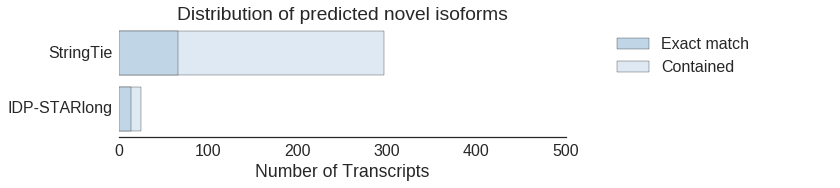

In [43]:
from matplotlib import gridspec
sns.set(style="white",font_scale=1.6)    
my_palette=sns.color_palette("Blues",n_colors=6)
mm="multi"
fig,ax = plt.subplots(figsize=(8, 2)) 
bin_labels=["Exact match","Contained"]
res=[]
A=[]
B=[]
labels=[]
nlabel={}
tlabel={}
for assembler in assemblers:
    a=gc_ens[assembler][mm]["="]
    b=gc_ens[assembler][mm]["c"]
    A.append(a)
    B.append(b)
    labels.append(assembler)
    nlabel[label]=a+b
    res_stat=single_multi_stats[assembler]                
    kk='Transcript_level_Sp'
    m=res_stat["multi"][kk]/100.0 if kk in res_stat["multi"] else 0
    n_m=res_stat["multi"]["n_t"]
    tlabel[label]=(a+b)/float(n_m*(1-m))*100
res.append(np.array(B)+np.array(A))
res.append(np.array(A))
my_data=DataFrame(np.array(res).transpose(),index=labels,columns=bin_labels[::-1])
for ii,b in enumerate(bin_labels[::-1]):
    cg=sns.barplot(data=my_data,x=b,y=labels,label=b, color=my_palette[ii],ax=ax)
ax.set_xlabel("Number of Transcripts")
ax.set_xticks(range(0,600,100))
sns.despine(left=True)    
handles, labels = ax.get_legend_handles_labels()
# reverse the order
ax.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.1, 0.85, 0.5, .102), 
      loc=1,ncol=1,
      mode="expand", borderaxespad=0.,frameon=False)

ax.set_title("Distribution of predicted novel isoforms")
